In [642]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.cm as cm

In [643]:
data = pd.read_csv("data.csv")
data.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [644]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

# 🧹 Čišćenje podataka: null vrijednosti i duplikati

In [646]:
print(data.isnull().sum())

Make                    0
Model                   0
Year                    0
Engine Fuel Type        3
Engine HP              69
Engine Cylinders       30
Transmission Type       0
Driven_Wheels           0
Number of Doors         6
Market Category      3742
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
dtype: int64


In [647]:
data['Engine Fuel Type'] = data['Engine Fuel Type'].fillna(data['Engine Fuel Type'].mode()[0])
data['Engine HP'] = data['Engine HP'].fillna(data['Engine HP'].median())
data['Engine Cylinders'] = data['Engine Cylinders'].fillna(data['Engine Cylinders'].median())
data['Number of Doors'] = data['Number of Doors'].fillna(data['Number of Doors'].mode()[0])
data.drop('Market Category', axis=1, inplace=True)
data.drop('Model', axis=1, inplace=True)

In [648]:
print(data.duplicated().sum()) 
data.drop_duplicates(inplace=True)

729


In [649]:
data['Transmission Type'] = data['Transmission Type'].replace('UNKNOWN', 'AUTOMATIC')
fuel_mapping = {
    'regular unleaded': 'regular',
    'premium unleaded (required)': 'premium',
    'premium unleaded (recommended)': 'premium',
    'flex-fuel (unleaded/E85)': 'flex-fuel',
    'flex-fuel (premium unleaded required/E85)': 'flex-fuel',
    'flex-fuel (premium unleaded recommended/E85)': 'flex-fuel',
    'flex-fuel (unleaded/natural gas)': 'flex-fuel',
    'diesel': 'diesel',
    'electric': 'electric',
    'natural gas': 'natural gas'
}
data['Engine Fuel Type'] = data['Engine Fuel Type'].map(fuel_mapping)

current_year = 2025
data['Vehicle Age'] = current_year - data['Year']
data.drop('Year', axis=1, inplace=True)

# 🛠️ Obrada podataka: Kategorijske varijable i skaliranje

In [651]:
data = data[data['Engine Cylinders'] != 0]

In [652]:
def remove_outliers_iqr_selected(df, columns, multiplier=1.5):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean

# Primjena samo na ključnim kolonama
key_cols = ['Engine HP', 'MSRP', 'Vehicle Age','Popularity']
data_no_out = remove_outliers_iqr_selected(data, key_cols)

print(f"Originalni broj redova: {len(data)}")
print(f"Nakon uklanjanja outliera: {len(data_no_out)}")

Originalni broj redova: 11129
Nakon uklanjanja outliera: 9198


In [653]:
# Kolone za one-hot enkodiranje
columns_to_encode = ['Make', 'Engine Fuel Type', 'Transmission Type', 'Driven_Wheels', 'Vehicle Size', 'Vehicle Style']

# Inicijalizacija OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit-transform na odabranim kolonama iz data_no_out
encoded_arrays = ohe.fit_transform(data_no_out[columns_to_encode])

# Dobivanje naziva novih kolona (feature names)
encoded_cols = ohe.get_feature_names_out(columns_to_encode)

# Pretvaranje u DataFrame s istim indeksom kao data_no_out
encoded_df = pd.DataFrame(encoded_arrays, columns=encoded_cols, index=data_no_out.index)

# Uklanjanje originalnih kategorijskih kolona
data_no_out_encoded = data_no_out.drop(columns=columns_to_encode)

# Dodavanje one-hot enkodiranih kolona u originalni DataFrame
data_encoded = pd.concat([data_no_out_encoded, encoded_df], axis=1)

In [654]:
scaler = StandardScaler()
numericke_varijable = ['Engine HP', 'Engine Cylinders','highway MPG','city mpg', 'Popularity', 'Vehicle Age','MSRP']
data_encoded[numericke_varijable] = scaler.fit_transform(data_encoded[numericke_varijable])

In [655]:
data_encoded.head()

,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,MSRP,Vehicle Age,Make_Acura,Make_Alfa Romeo,...,Vehicle Style_Convertible,Vehicle Style_Convertible SUV,Vehicle Style_Coupe,Vehicle Style_Crew Cab Pickup,Vehicle Style_Extended Cab Pickup,Vehicle Style_Passenger Minivan,Vehicle Style_Passenger Van,Vehicle Style_Regular Cab Pickup,Vehicle Style_Sedan,Vehicle Style_Wagon
0,1.359173,0.469177,2.0,-0.14585,-0.157570,3.148674,1.088186,-0.057022,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.911388,0.469177,2.0,0.12184,-0.157570,3.148674,0.731067,-0.057022,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.911388,0.469177,2.0,0.12184,-0.002793,3.148674,0.451101,-0.057022,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.015818,0.469177,2.0,0.12184,-0.312347,3.148674,0.001853,-0.057022,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.015818,0.469177,2.0,0.12184,-0.312347,3.148674,0.330650,-0.057022,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [656]:

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_encoded)

data_encoded['cluster'] = clusters

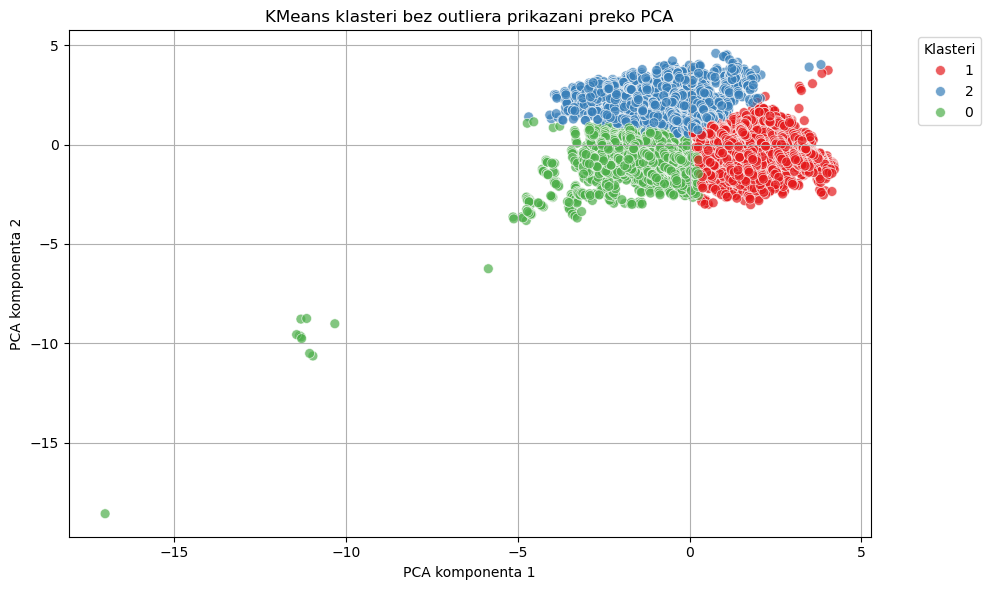

Silhouette Score: 0.1901
Davies-Bouldin Index: 1.6966
Calinski-Harabasz Index: 2023.4149


In [657]:
labels = data_encoded['cluster']
X = data_encoded.drop(columns=['cluster'])

# Ukloni outliere (-1) iz podataka i labela
mask = labels != -1
X_no_outliers = X[mask]
labels_no_outliers = labels[mask]

# PCA na podatke bez outliera
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_no_outliers)

# Broj klastera
n_clusters = labels_no_outliers.nunique()

# Priprema DataFrame-a za seaborn
df_vis = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'Klaster': labels_no_outliers.astype(str)  # pretvaramo u string radi hue
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_vis, x='PCA1', y='PCA2', hue='Klaster', palette='Set1', s=50, alpha=0.7)
plt.title('KMeans klasteri bez outliera prikazani preko PCA')
plt.xlabel('PCA komponenta 1')
plt.ylabel('PCA komponenta 2')
plt.legend(title='Klasteri', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluacija modela bez outliera
sil_score = silhouette_score(X_no_outliers, labels_no_outliers)
db_score = davies_bouldin_score(X_no_outliers, labels_no_outliers)
ch_score = calinski_harabasz_score(X_no_outliers, labels_no_outliers)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_score:.4f}")
print(f"Calinski-Harabasz Index: {ch_score:.4f}")

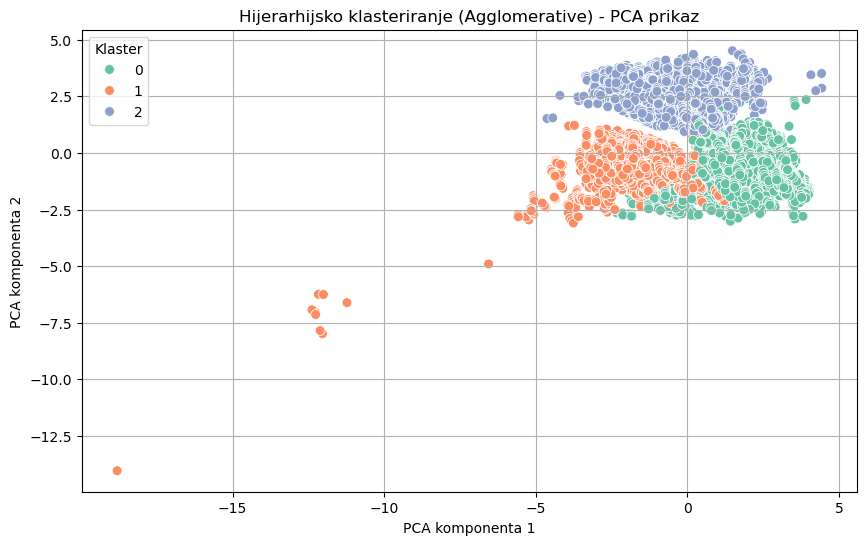

Silhouette Score: 0.2089
Davies-Bouldin Index: 1.6088
Calinski-Harabasz Index: 2182.6706


In [658]:
# 1. Agglomerative Clustering s 3 klastera
agglo = AgglomerativeClustering(n_clusters=3)
labels_agglo = agglo.fit_predict(data_encoded)

# 2. PCA radi prikaza u 2D
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_encoded)

# 3. Vizualizacija
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_2d[:, 0], y=data_2d[:, 1], hue=labels_agglo, palette="Set2", s=50)
plt.title("Hijerarhijsko klasteriranje (Agglomerative) - PCA prikaz")
plt.xlabel("PCA komponenta 1")
plt.ylabel("PCA komponenta 2")
plt.legend(title="Klaster")
plt.grid(True)
plt.show()

# 4. Evaluacija modela (računamo na cijelim podacima jer ovdje nema outliera)
sil_score = silhouette_score(data_encoded, labels_agglo)
db_score = davies_bouldin_score(data_encoded, labels_agglo)
ch_score = calinski_harabasz_score(data_encoded, labels_agglo)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_score:.4f}")
print(f"Calinski-Harabasz Index: {ch_score:.4f}")


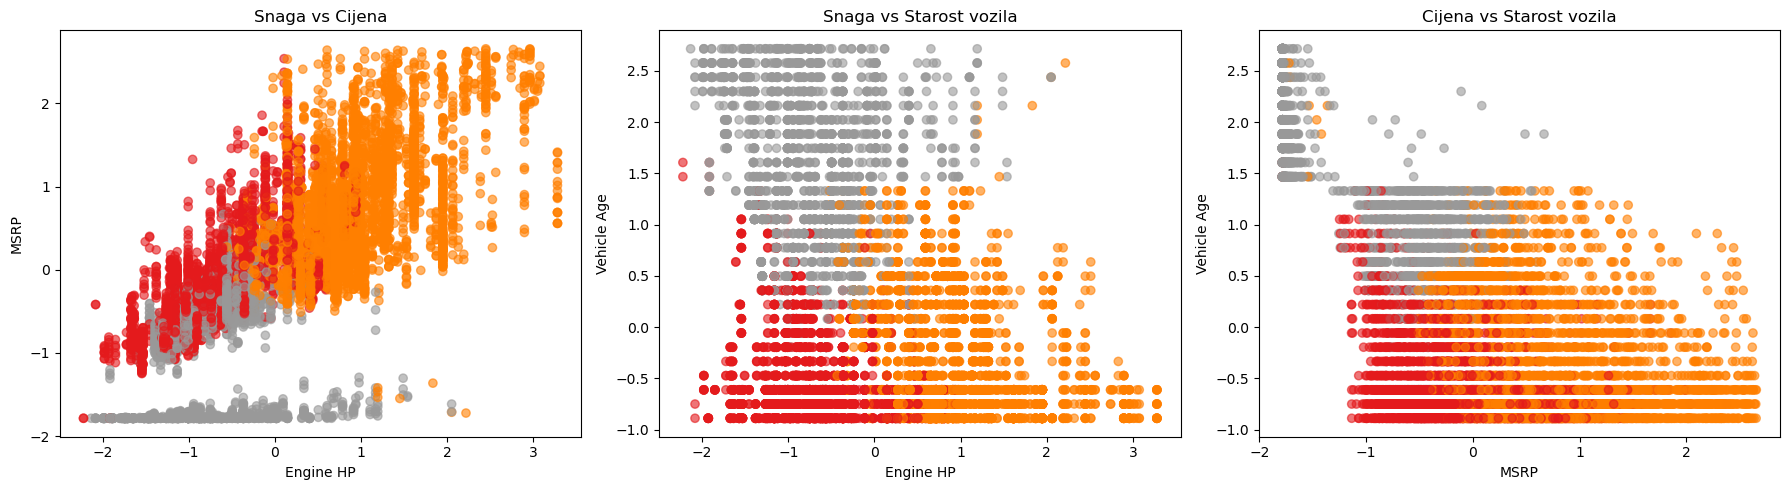

In [659]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(data_encoded['Engine HP'], data_encoded['MSRP'], c=data_encoded['cluster'], cmap='Set1', alpha=0.6)
axs[0].set_xlabel('Engine HP')
axs[0].set_ylabel('MSRP')
axs[0].set_title('Snaga vs Cijena')

axs[1].scatter(data_encoded['Engine HP'], data_encoded['Vehicle Age'], c=data_encoded['cluster'], cmap='Set1', alpha=0.6)
axs[1].set_xlabel('Engine HP')
axs[1].set_ylabel('Vehicle Age')
axs[1].set_title('Snaga vs Starost vozila')

axs[2].scatter(data_encoded['MSRP'], data_encoded['Vehicle Age'], c=data_encoded['cluster'], cmap='Set1', alpha=0.6)
axs[2].set_xlabel('MSRP')
axs[2].set_ylabel('Vehicle Age')
axs[2].set_title('Cijena vs Starost vozila')

plt.tight_layout()
plt.show()

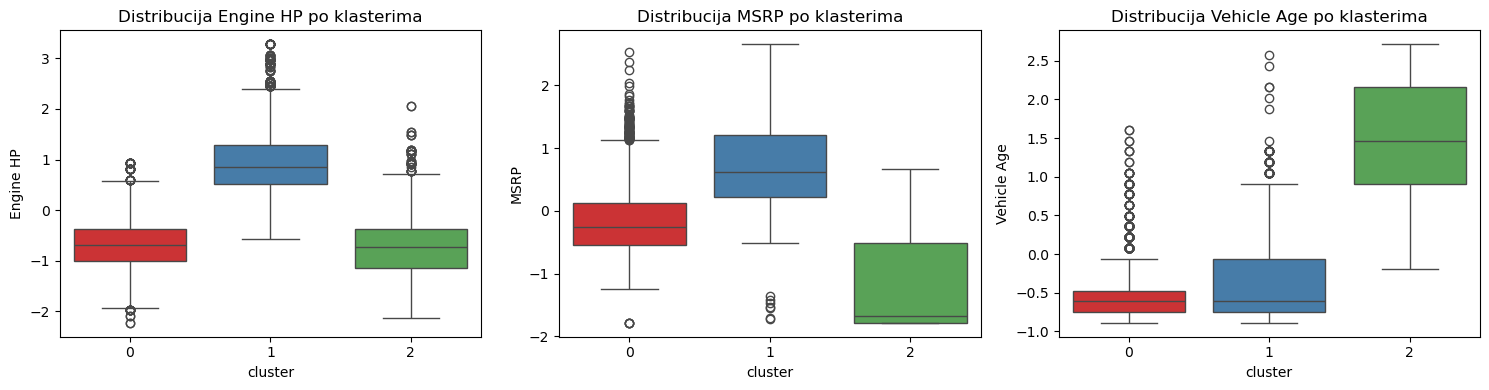

In [660]:
features = ['Engine HP', 'MSRP', 'Vehicle Age']

plt.figure(figsize=(15, 4))
for i, feat in enumerate(features):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(x='cluster', y=feat, data=data_encoded, hue='cluster', palette='Set1', legend=False)
    plt.title(f'Distribucija {feat} po klasterima')
plt.tight_layout()
plt.show()
